In [1]:
import pandas as pd
import pymc3 as pm
import numpy as np
from sklearn.preprocessing import StandardScaler
import arviz as az

In [2]:
df_train = pd.read_csv('data/DailyDelhiClimateTrain.csv')
df_test = pd.read_csv('data/DailyDelhiClimateTest.csv')

In [3]:
df_train.shape

(1462, 5)

In [4]:
df_test.shape

(114, 5)

In [5]:
df_train.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [6]:
df_test.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333


In [7]:
# Import the adfuller function from the statsmodels module
from statsmodels.tsa.stattools import adfuller

# Create a function to apply the Augmented Dickey Fuller test
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [8]:
columns_to_test = df_train.drop('date', axis=1).columns

for column in columns_to_test:
    print(f'ADF Test Results for {column}:')
    adf_test(df_train[column])
    print('\n')

ADF Test Results for meantemp:
Results of Dickey-Fuller Test:
Test Statistic                   -2.021069
p-value                           0.277412
#Lags Used                       10.000000
Number of Observations Used    1451.000000
Critical Value (1%)              -3.434865
Critical Value (5%)              -2.863534
Critical Value (10%)             -2.567832
dtype: float64


ADF Test Results for humidity:
Results of Dickey-Fuller Test:
Test Statistic                   -3.675577
p-value                           0.004470
#Lags Used                       15.000000
Number of Observations Used    1446.000000
Critical Value (1%)              -3.434880
Critical Value (5%)              -2.863541
Critical Value (10%)             -2.567835
dtype: float64


ADF Test Results for wind_speed:
Results of Dickey-Fuller Test:
Test Statistic                   -3.838097
p-value                           0.002541
#Lags Used                       24.000000
Number of Observations Used    1437.000000
Crit

# Interpeting results

Excluding meantemp, the features are stationary as the test statistic is lower than the critical values (with more than 99% confidence).
In order to meet the assumptions for Bayesian forecasting, we will difference meantemp to try to make it stationary.

In [9]:
# Function to difference series
def difference(dataset):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i - 1]
        diff.append(value)
    return pd.Series(diff)

# difference the 'meantemp' series
diff_meantemp = difference(df_train['meantemp'])

# You can print the differenced series
print(diff_meantemp)

0      -2.600000
1      -0.233333
2       1.500000
3      -2.666667
4       1.000000
          ...   
1456    0.367391
1457   -1.979296
1458   -1.142857
1459    0.957393
1460   -5.052632
Length: 1461, dtype: float64


In [10]:
# create a new dataframe, dropping the first row from the original df_train
# as the differenced series is now shorter by 1
df_train_diff = df_train.drop(df_train.index[0])

# replace the 'meantemp' column with the differenced series
df_train_diff['meantemp'] = diff_meantemp.values

# run adftest to see if it's now stationary
adf_test(df_train_diff['meantemp'])

Results of Dickey-Fuller Test:
Test Statistic                -1.637872e+01
p-value                        2.764863e-29
#Lags Used                     9.000000e+00
Number of Observations Used    1.451000e+03
Critical Value (1%)           -3.434865e+00
Critical Value (5%)           -2.863534e+00
Critical Value (10%)          -2.567832e+00
dtype: float64


# Success!
All of our features look to be stationary. At the moment, we won't check for the other assumptions of Bayesian forecasting:

- No serial correlation
- Homoscedasticity
- No endogeneity

Now we can begin applying BVAR via pymc3.

/Users/daniel/opt/anaconda3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [meanpressure_prior, wind_speed_prior, humidity_prior, mean_temp_prior]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 25 seconds.


/Users/daniel/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


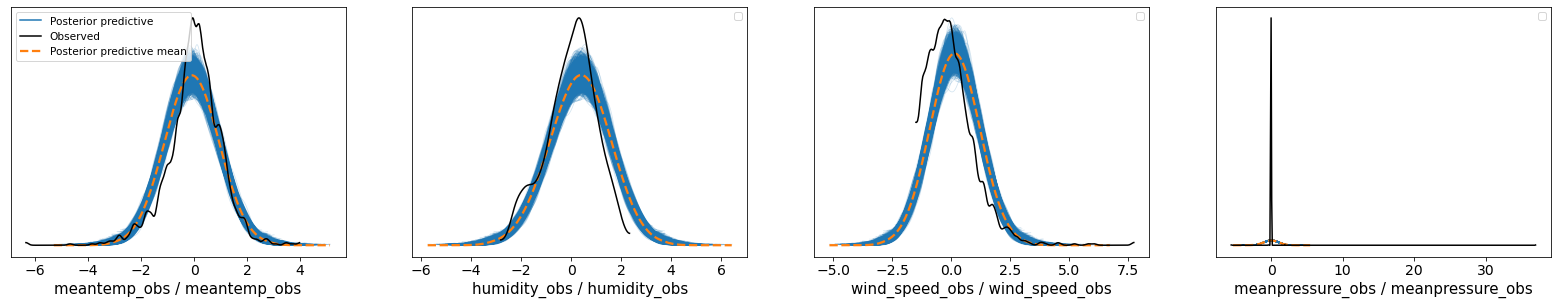

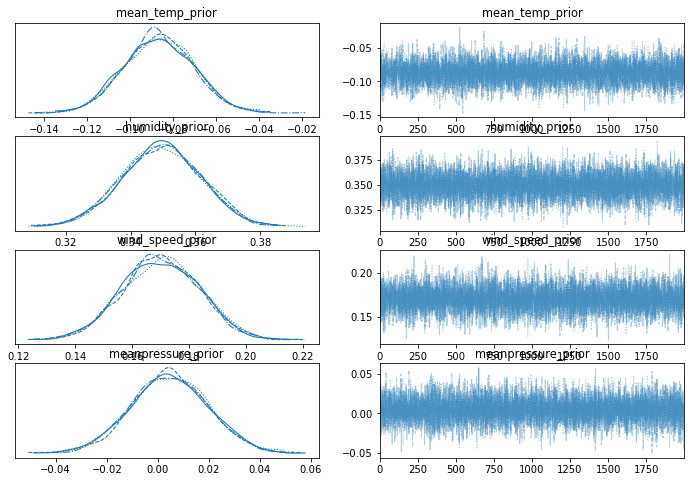

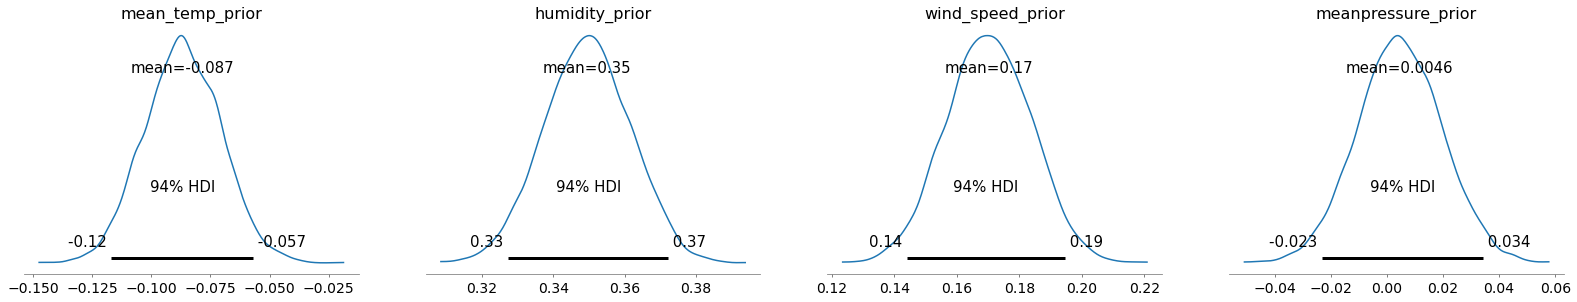

In [21]:
# We standardize our data to have zero mean and unit variance for better results
scaler = StandardScaler()
df_train_scaled = pd.DataFrame(scaler.fit_transform(df_train_diff.drop('date', axis=1)),
                               columns=df_train_diff.columns.drop('date'))

# We standardize our data to have zero mean and unit variance for better results
scaler = StandardScaler()
df_train_scaled = pd.DataFrame(scaler.fit_transform(df_train_diff.drop('date', axis=1)),
                               columns=df_train_diff.columns.drop('date'))

# Number of lags
n_lags = 2

# Create lags
for col in df_train_scaled.columns:
    for lag in range(1, n_lags+1):
        df_train_scaled[col+'_lag'+str(lag)] = df_train_scaled[col].shift(lag)

# Drop rows with missing values
df_train_scaled.dropna(inplace=True)

with pm.Model() as model:

    # Priors
    mean_temp_prior = pm.Normal('mean_temp_prior', mu=0, sd=10)
    humidity_prior = pm.Normal('humidity_prior', mu=0, sd=10)
    wind_speed_prior = pm.Normal('wind_speed_prior', mu=0, sd=10)
    meanpressure_prior = pm.Normal('meanpressure_prior', mu=0, sd=10)

    # Theano shared variables
    shared_vars = {var: pm.Data(var, df_train_scaled[var]) for var in df_train_scaled.columns}

    # BVAR model
    mu = mean_temp_prior + pm.math.dot(shared_vars['meantemp_lag1'], mean_temp_prior) + pm.math.dot(shared_vars['meantemp_lag2'], mean_temp_prior)
    hum = humidity_prior + pm.math.dot(shared_vars['humidity_lag1'], humidity_prior) + pm.math.dot(shared_vars['humidity_lag2'], humidity_prior)
    wind = wind_speed_prior + pm.math.dot(shared_vars['wind_speed_lag1'], wind_speed_prior) + pm.math.dot(shared_vars['wind_speed_lag2'], wind_speed_prior)
    pressure = meanpressure_prior + pm.math.dot(shared_vars['meanpressure_lag1'], meanpressure_prior) + pm.math.dot(shared_vars['meanpressure_lag2'], meanpressure_prior)
    
    meantemp_obs = pm.Normal('meantemp_obs', mu=mu, sd=1, observed=shared_vars['meantemp'])
    humidity_obs = pm.Normal('humidity_obs', mu=hum, sd=1, observed=shared_vars['humidity'])
    wind_speed_obs = pm.Normal('wind_speed_obs', mu=wind, sd=1, observed=shared_vars['wind_speed'])
    meanpressure_obs = pm.Normal('meanpressure_obs', mu=pressure, sd=1, observed=shared_vars['meanpressure'])

    # MCMC
    trace = pm.sample(2000, tune=1000)
    
    ppc = pm.sample_posterior_predictive(trace)
    # Convert to InferenceData format
    idata = az.from_pymc3(trace, posterior_predictive = ppc)
    az.plot_ppc(idata)
    az.plot_trace(idata)
    az.plot_posterior(idata)

In [22]:
summary = az.summary(trace, hdi_prob=0.95)  # hdi_prob can be set as per your requirement for HDI
print(summary)

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/daniel/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


                     mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
mean_temp_prior    -0.087  0.016    -0.118     -0.055        0.0      0.0   
humidity_prior      0.350  0.012     0.327      0.373        0.0      0.0   
wind_speed_prior    0.170  0.014     0.144      0.196        0.0      0.0   
meanpressure_prior  0.005  0.015    -0.023      0.036        0.0      0.0   

                    ess_bulk  ess_tail  r_hat  
mean_temp_prior      12669.0    6327.0    1.0  
humidity_prior       12056.0    6046.0    1.0  
wind_speed_prior     13500.0    6549.0    1.0  
meanpressure_prior   13198.0    5502.0    1.0  


Got error No model on context stack. trying to find log_likelihood in translation.
/Users/daniel/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:ylabel='humidity_prior'>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='wind_speed_prior'>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='mean_temp_prior', ylabel='meanpressure_prior'>,
        <AxesSubplot:xlabel='humidity_prior'>,
        <AxesSubplot:xlabel='wind_speed_prior'>]], dtype=object)

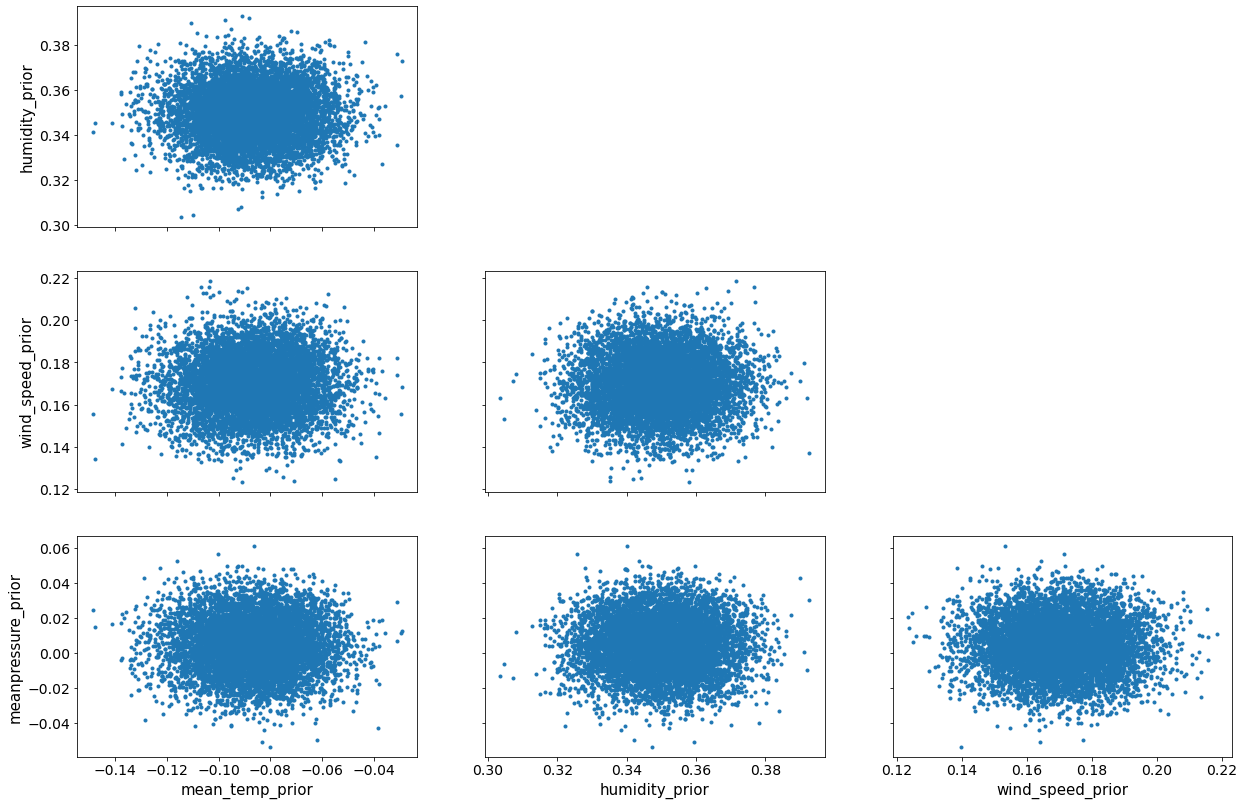

In [16]:
az.plot_pair(trace, var_names=['mean_temp_prior', 'humidity_prior', 'wind_speed_prior', 'meanpressure_prior'])

# Issues
At the moment, there are some issues. The ppc plot shows that we aren't predicting the observation well. This will be eventually returned to.

In [29]:
az.rhat(idata)

<xarray.Dataset>
Dimensions:             ()
Data variables:
    mean_temp_prior     float64 1.0
    humidity_prior      float64 1.0
    wind_speed_prior    float64 1.001
    meanpressure_prior  float64 1.002

# Convergence
An $\hat{R}$ greater than 1 shows that some chains have not yet converged.